<a href="https://colab.research.google.com/github/YosukeSugiura/piglet_voice_detection/blob/main/Piglet_voice_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ブタちゃんの鳴き声の解析

In [67]:
#@title まずは必要なモジュールをインストール
!pip install japanize-matplotlib -U &> /dev/null

In [68]:
#@title モジュールインポート
import sys
import numpy as np
import soundfile as sf
import urllib.request 
from google.colab import output
from librosa import stft, istft, amplitude_to_db
from librosa.display import specshow
import matplotlib.pyplot as plt
from IPython.display import display, Audio

### 産後直後の泣き声(高コレステロール)

## 読み込みと表示

In [69]:
#@title wavファイルの読み込み
# wavファイルをGoogle colabのワークスペースにもってくる
urllib.request.urlretrieve('https://raw.githubusercontent.com/YosukeSugiura/piglet_voice_detection/master/Baby_immed_High_Cholesterol_1.wav', 'sound1.wav')
# wavファイルの読み込み
x, fs = sf.read('sound1.wav')  # 戻り値：データ, サンプリング周波数
print('Input Size : {0}'.format(x.shape))

xl = x[:,0]     # 左チャンネル
xr = x[:,1]     # 右チャンネル

# デバッグ用：
# データ長が長いので制限．本番ではコメントアウト
xl = xl[:fs*10] # 10秒データ
xr = xr[:fs*10] # 10秒データ

t = np.arange(len(xl))/fs # 各サンプルの時刻(波形の図示で使う)

Input Size : (2729088, 2)


In [70]:
#@title 周波数解析
# パラメータ
N = 512        # セグメント長
nfft = 2048    # FFT点数
S = N//2    # シフト幅

# 短時間フーリエ変換
Xl = stft(xl, n_fft=nfft, win_length=N ,hop_length=S)
Xr = stft(xr, n_fft=nfft, win_length=N, hop_length=S)

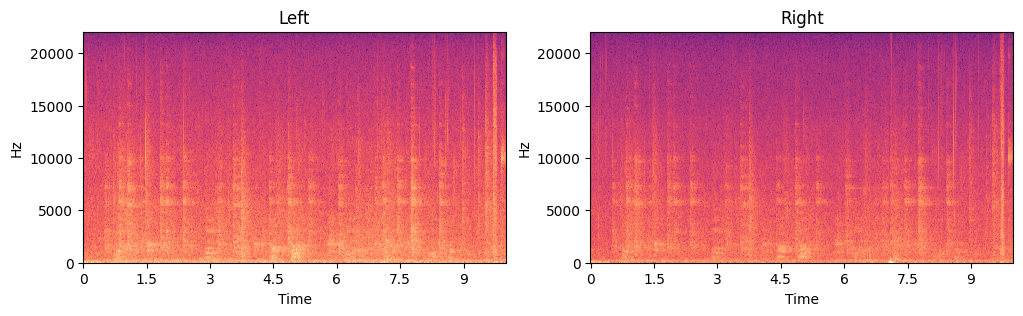

In [71]:
#@title スペクトログラム表示
plt.figure(figsize=(12, 3))
for i, (X, Ch) in enumerate(zip([Xl, Xr], ['Left', 'Right'])):
    plt.subplot(1, 2, i+1)
    specshow(20*np.log10(np.abs(X)), sr=fs, hop_length=S, x_axis='time', y_axis='linear',cmap='magma')
    plt.title(Ch)

## ノイズ除去

In [72]:
#@title 1. 指向性の形成

# パラメータ
Dm = 2                # マイク間距離 [cm]
c = 340*100      # 音速 [cm/s]
Theta = 30 # 指向性角度 [°]

# 遅延距離 [cm]
D = Dm * np.sin(2*np.pi*Theta/360)

# 遅延サンプル数
T = D * fs / c

# 時間シフト
w = np.arange(nfft//2+1)/nfft   # 離散周波数アレイ
E  = np.exp(-1j*T*w)             # 位相シフト量
Xr_shift = E[:,np.newaxis]*Xr # シフトした右チャンネル信号

# 指向性音響信号
X_dir = Xl + Xr_shift

In [73]:
#@title 2. 周波数フィルタ

# 高域通過フィルタ (低域カット)
fc = 300  # カット周波数 [Hz]
ic = np.round(nfft * fc / fs, ).astype(int) # 周波数ビンに変換

# フィルタリング (0ではなく小さい値を入れる)
X_cut = np.copy(X_dir)
X_cut[:ic,:] = 10**(-3)

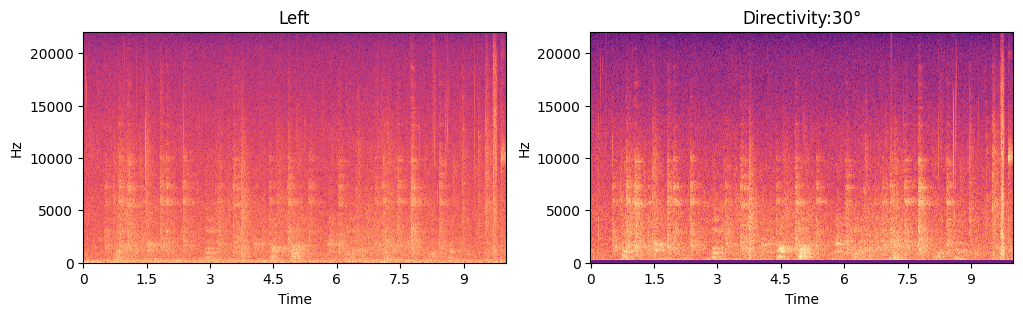

In [74]:
#@title スペクトログラム表示
plt.figure(figsize=(12, 3))
for i, (X, Ch) in enumerate(zip([Xl, X_cut], ['Left', 'Directivity:{0}°'.format(Theta)])):
    plt.subplot(1, 2, i+1)
    specshow(20*np.log10(np.abs(X)), sr=fs, hop_length=S, x_axis='time', y_axis='linear',cmap='magma')
    plt.title(Ch)

In [75]:
#@title 音声ファイルに保存
y = istft(X_dir, hop_length=S, win_length=N, n_fft=nfft)
sf.write(file='noise_reduction.wav', data=y, samplerate=fs)

print('Input (Left):')
display(Audio(xl, rate=fs))

print('Output:')
display(Audio(y, rate=fs))

Input (Left):


Output:


## 高域抽出 & 可聴化

In [76]:
# パラメータ
fl = 16000  # 抽出する下限周波数 [Hz]
ic = np.round(nfft * fl / fs, ).astype(int) # 周波数ビンに変換

# 下限周波数以上を抽出
X_ext = X_cut[ic+1:,:]      # 抽出したスペクトログラム
n_freq_ext = X_ext.shape[0]  # 抽出後の周波数ビンの数
n_fft_ext = (n_freq_ext-1)*2  # 抽出後のFFT点数

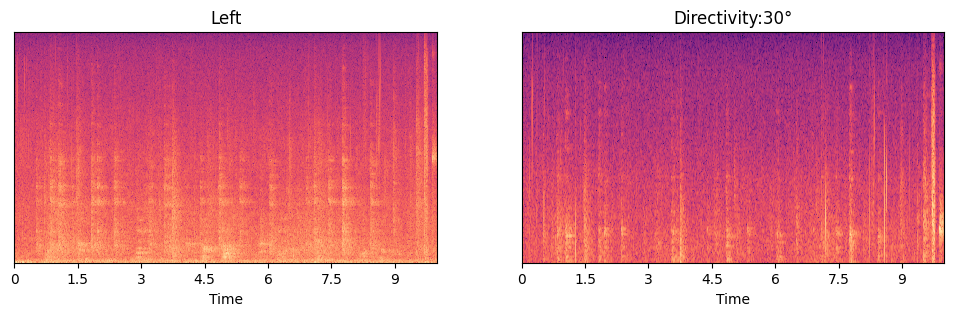

In [77]:
#@title スペクトログラム表示
plt.figure(figsize=(12, 3))
for i, (X, Ch) in enumerate(zip([Xl, X_ext], ['Left', 'Directivity:{0}°'.format(Theta)])):
    plt.subplot(1, 2, i+1)
    specshow(20*np.log10(np.abs(X)), sr=fs, hop_length=S, x_axis='time',cmap='magma')
    plt.title(Ch)

In [78]:
#@title 音声ファイルに保存
y = istft(X_ext, hop_length=S, win_length=N, n_fft=n_fft_ext)
sf.write(file='super_high_components.wav', data=y, samplerate=fs)

print('Input (Left):')
display(Audio(xl, rate=fs))

print('Output:')
display(Audio(y, rate=fs))

Input (Left):


Output:
